In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import time


## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed
gdrive = "."

In [2]:
print(tf.__version__)
print(tf.keras.__version__)

2.4.1
2.4.0


In [3]:
#data generator class
class DataGen(keras.utils.Sequence):
    def __init__(self, train_ids, train_path, batch_size=3, image_size=1024):
        self.ids = train_ids;
        self.path = train_path;
        self.batch_size = batch_size;
        self.image_size = image_size;
        self.on_epoch_end();
        
    def __load__(self, id_name):
        #defining path for the training data set
        
        id_name_mask = id_name.replace(".JPG",".png").replace(".jpg",".png")
        

        image_path = os.path.join(self.path, "images", id_name);
        mask_path = os.path.join(self.path, "masks", id_name_mask); #mascaras estao em .png
        
        # reading the image from dataset
        ## Reading Image
        image = cv2.imread(image_path, 1); #reading image to image vaiable
        image = cv2.resize(image, (self.image_size, self.image_size));
        mask = cv2.imread(mask_path, 0); #mask image of same size with all zeros
        mask = cv2.resize(mask, (self.image_size ,self.image_size));
        mask = np.expand_dims(mask, axis=-1);
        #image normalisation
        image = image / 255.0;
        mask = mask / 255.0;
        
        return image, mask;
    
    def __getitem__(self, index): #index : batch no.
        
        if(index+1)*self.batch_size > len(self.ids): # redining last batch size
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size] #list of 10 image ids
        
        image = [] #collection of 10 images
        mask  = [] #collection of 10 masks
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name);
            image.append(_img);
            mask.append(_mask);
            
        image = np.array(image);
        mask  = np.array(mask);
        
        return image, mask; #return array of 10 images and 10 masks
    
    #for printing the statistics of the function
    def on_epoch_end(self):
        print("epoch completed");
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));#length of the epoch as length of generation DataGen obj

In [4]:

#hyperparameter
image_size = 256;
train_path = gdrive + "/malaria_broadinstitute_relabeled-unet/"; #address of the dataset
#train_path = gdrive + "/data-1024x1024/"; #address of the dataset
#train_path = gdrive + "/data-1024x1024/"; #address of the dataset
epochs = 1000; #number of time we need to train dataset
batch_size = 100; #tarining batch size

#train path
train_ids = os.listdir(train_path + "/images")
#Validation Data Size
val_data_size = 1; #size of set of images used for the validation 

valid_ids = train_ids[:val_data_size]; # list of image ids used for validation of result 0 to 9
train_ids = train_ids[val_data_size:]; #list of image ids used for training dataset
#print(valid_ids, "\n\n");
print("training_size: ", len(train_ids), "validation_size: ", len(valid_ids))

#making generator object
gen = DataGen(train_ids, train_path, batch_size, image_size);
print("total epoch: ", len(gen))
#print(valid_ids)

training_size:  3014 validation_size:  1
epoch completed
total epoch:  31


shape of the batch (100, 256, 256, 3) (100, 256, 256, 1)
Number of images in the batch:  100


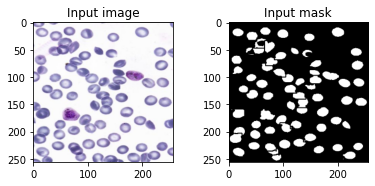

In [5]:
#Analysing sample of the dataset from data generator


#getting image_set data from dataset
x, y = gen.__getitem__(0); # self = gen and index = 0 each item is a set of 8 images
print("shape of the batch", x.shape, y.shape);
print("Number of images in the batch: ", len(x));

#display of the sample of the data zeroth image

fig = plt.figure();
fig.subplots_adjust(hspace=0.4, wspace=0.4); #reserving height above plot and space between plots
ax = fig.add_subplot(1, 2, 1); #figure of 1 row 2 columns and 1st image
x1 = (x[2]*255).astype(np.uint8);
x1 = cv2.cvtColor(x1, cv2.COLOR_BGR2RGB);
ax.imshow(x1);
plt.title("Input image");

ax = fig.add_subplot(1, 2, 2); #2nd image plot
ax.imshow(np.reshape(y[2], (image_size, image_size)), cmap="gray");
plt.title("Input mask");

In [6]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [7]:
def UNet(size):
    if (size == 128):
        return UNet128()
    elif (size == 256):
        return UNet256()
    elif (size == 512):
        return UNet512()
    elif (size == 1024):
        return UNet1024()
    
def UNet1024():
    f = [16, 32, 64, 128, 256, 512, 1024, 2048]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128 image to 512
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 256
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 128
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 64
    c5, p5 = down_block(p4, f[4]) #pooling layer downsmaples 128 image to 32
    c6, p6 = down_block(p5, f[5]) #pooling layer downsmaples 128 image to 16
    c7, p7 = down_block(p6, f[6]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p7, f[7])
    
    u1 = up_block(bn, c7, f[6]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c6, f[5]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c5, f[4]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c4, f[3]) #upsampling layer upsmaples 8 image to 128
    u5 = up_block(u4, c3, f[2]) #upsampling layer upsmaples 8 image to 256
    u6 = up_block(u5, c2, f[1]) #upsampling layer upsmaples 8 image to 512
    u7 = up_block(u6, c1, f[0]) #upsampling layer upsmaples 8 image to 512
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u7)
    model = keras.models.Model(inputs, outputs)
    return model
    

#unet model
def UNet512():
    f = [16, 32, 64, 128, 256, 512, 1024]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0], kernel_size=(15,15)) #pooling layer downsmaples 128 image to 256
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 128
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 64
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 32
    c5, p5 = down_block(p4, f[4]) #pooling layer downsmaples 128 image to 16
    c6, p6 = down_block(p5, f[5]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p6, f[6])
    
    u1 = up_block(bn, c6, f[5]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c5, f[4]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c4, f[3]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c3, f[2]) #upsampling layer upsmaples 8 image to 128
    u5 = up_block(u4, c2, f[1]) #upsampling layer upsmaples 8 image to 256
    u6 = up_block(u5, c1, f[0], kernel_size=(15,15)) #upsampling layer upsmaples 8 image to 512
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u6)
    model = keras.models.Model(inputs, outputs)
    return model

def UNet256():
    f = [16, 32, 64, 128, 256, 512]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128 image to 128
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 64
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 32
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 16
    c5, p5 = down_block(p4, f[4]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p5, f[5])
    
    u1 = up_block(bn, c5, f[4]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c4, f[3]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c3, f[2]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c2, f[1]) #upsampling layer upsmaples 8 image to 128
    u5 = up_block(u4, c1, f[0]) #upsampling layer upsmaples 8 image to 256
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u5)
    model = keras.models.Model(inputs, outputs)
    return model


def UNet128():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128 image to 64
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128 image to 32
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128 image to 16
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128 image to 8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #upsampling layer upsmaples 8 image to 16
    u2 = up_block(u1, c3, f[2]) #upsampling layer upsmaples 8 image to 32
    u3 = up_block(u2, c2, f[1]) #upsampling layer upsmaples 8 image to 64
    u4 = up_block(u3, c1, f[0]) #upsampling layer upsmaples 8 image to 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

def impHistoria(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.title('train loss'); plt.ylabel('MSE loss'); plt.xlabel('epoch')
    plt.legend(['train loss'], loc='upper left')
    plt.show()
    plt.plot(history.history['acc'])
    plt.title('train accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch')
    plt.legend(['train accuracy'], loc='upper left')
    plt.show()

In [8]:
model = UNet(image_size)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
batch_size = 10
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size);
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size);
print("total training batches: ", len(train_gen));
print("total validaton batches: ", len(valid_gen));
train_steps = len(train_ids)//batch_size;
valid_steps = len(valid_ids)//batch_size;
#epochs = 1000
versao = 1

_fileName = gdrive + "/cells-newdataset-%d-%d-30-v%d-tf241.h5"
filename = _fileName % (image_size, epochs, versao)

print("filename:",filename)

epoch completed
epoch completed
total training batches:  302
total validaton batches:  1
filename: ./cells-newdataset-256-1000-30-v1-tf241.h5


Epoch 1/1000
301/301 [==============================] - 79s 247ms/step - loss: 0.1725 - acc: 0.9075
epoch completed
Epoch 2/1000
301/301 [==============================] - 32s 105ms/step - loss: 0.1001 - acc: 0.9364
epoch completed
Epoch 3/1000
301/301 [==============================] - 22s 66ms/step - loss: 0.0914 - acc: 0.9380
epoch completed
Epoch 4/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0836 - acc: 0.9416
epoch completed
Epoch 5/1000
301/301 [==============================] - 20s 68ms/step - loss: 0.0974 - acc: 0.9376
epoch completed
Epoch 6/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0764 - acc: 0.9445
epoch completed
Epoch 7/1000
301/301 [==============================] - 20s 68ms/step - loss: 0.0786 - acc: 0.9432
epoch completed
Epoch 8/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0774 - acc: 0.9434
epoch completed
Epoch 9/1000
301/301 [==============================] - 20s 66ms/step - loss: 

epoch completed
Epoch 40/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0680 - acc: 0.9455
epoch completed
Epoch 41/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0664 - acc: 0.9464
epoch completed
Epoch 42/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0657 - acc: 0.9464
epoch completed
Epoch 43/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0667 - acc: 0.9457
epoch completed
Epoch 44/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0664 - acc: 0.9462
epoch completed
Epoch 45/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0641 - acc: 0.9474
epoch completed
Epoch 46/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0634 - acc: 0.9478
epoch completed
Epoch 47/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0669 - acc: 0.9457
epoch completed
Epoch 48/1000
301/301 [==============================] -

epoch completed
Epoch 79/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0595 - acc: 0.9490
epoch completed
Epoch 80/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0576 - acc: 0.9498
epoch completed
Epoch 81/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0582 - acc: 0.9495
epoch completed
Epoch 82/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0559 - acc: 0.9510
epoch completed
Epoch 83/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0588 - acc: 0.9491
epoch completed
Epoch 84/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0644 - acc: 0.9474
epoch completed
Epoch 85/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0616 - acc: 0.9488
epoch completed
Epoch 86/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0571 - acc: 0.9504
epoch completed
Epoch 87/1000
301/301 [==============================] -

epoch completed
Epoch 118/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0603 - acc: 0.9487
epoch completed
Epoch 119/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0586 - acc: 0.9498
epoch completed
Epoch 120/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0565 - acc: 0.9502
epoch completed
Epoch 121/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0551 - acc: 0.9509
epoch completed
Epoch 122/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0535 - acc: 0.9518
epoch completed
Epoch 123/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0538 - acc: 0.9511
epoch completed
Epoch 124/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0552 - acc: 0.9503
epoch completed
Epoch 125/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0541 - acc: 0.9507
epoch completed
Epoch 126/1000
301/301 [========================

epoch completed
Epoch 157/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0537 - acc: 0.9511
epoch completed
Epoch 158/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0510 - acc: 0.9530
epoch completed
Epoch 159/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0539 - acc: 0.9511
epoch completed
Epoch 160/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0518 - acc: 0.9519
epoch completed
Epoch 161/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0532 - acc: 0.9517
epoch completed
Epoch 162/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0535 - acc: 0.9513
epoch completed
Epoch 163/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0514 - acc: 0.9525
epoch completed
Epoch 164/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0550 - acc: 0.9503
epoch completed
Epoch 165/1000
301/301 [========================

epoch completed
Epoch 196/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0530 - acc: 0.9513
epoch completed
Epoch 197/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0485 - acc: 0.9538
epoch completed
Epoch 198/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0500 - acc: 0.9527
epoch completed
Epoch 199/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0515 - acc: 0.9516
epoch completed
Epoch 200/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0521 - acc: 0.9515
epoch completed
Epoch 201/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0507 - acc: 0.9521
epoch completed
Epoch 202/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0509 - acc: 0.9521
epoch completed
Epoch 203/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0522 - acc: 0.9511
epoch completed
Epoch 204/1000
301/301 [========================

epoch completed
Epoch 235/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0502 - acc: 0.9523
epoch completed
Epoch 236/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0465 - acc: 0.9551
epoch completed
Epoch 237/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0500 - acc: 0.9529
epoch completed
Epoch 238/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0507 - acc: 0.9521
epoch completed
Epoch 239/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0485 - acc: 0.9538
epoch completed
Epoch 240/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0509 - acc: 0.9520
epoch completed
Epoch 241/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0498 - acc: 0.9530
epoch completed
Epoch 242/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0513 - acc: 0.9518
epoch completed
Epoch 243/1000
301/301 [========================

epoch completed
Epoch 274/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0497 - acc: 0.9521
epoch completed
Epoch 275/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0513 - acc: 0.9516
epoch completed
Epoch 276/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0481 - acc: 0.9536
epoch completed
Epoch 277/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0489 - acc: 0.9531
epoch completed
Epoch 278/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0495 - acc: 0.9526
epoch completed
Epoch 279/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0475 - acc: 0.9542
epoch completed
Epoch 280/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0473 - acc: 0.9538
epoch completed
Epoch 281/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0513 - acc: 0.9514
epoch completed
Epoch 282/1000
301/301 [========================

epoch completed
Epoch 313/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0488 - acc: 0.9530
epoch completed
Epoch 314/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0493 - acc: 0.9527
epoch completed
Epoch 315/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0496 - acc: 0.9521
epoch completed
Epoch 316/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0453 - acc: 0.9553
epoch completed
Epoch 317/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0492 - acc: 0.9522
epoch completed
Epoch 318/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0494 - acc: 0.9524
epoch completed
Epoch 319/1000
301/301 [==============================] - 20s 68ms/step - loss: 0.0459 - acc: 0.9545
epoch completed
Epoch 320/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0486 - acc: 0.9527
epoch completed
Epoch 321/1000
301/301 [========================

epoch completed
Epoch 352/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0463 - acc: 0.9540
epoch completed
Epoch 353/1000
301/301 [==============================] - 21s 68ms/step - loss: 0.0489 - acc: 0.9523
epoch completed
Epoch 354/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0451 - acc: 0.9549
epoch completed
Epoch 355/1000
301/301 [==============================] - 20s 68ms/step - loss: 0.0471 - acc: 0.9539
epoch completed
Epoch 356/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0449 - acc: 0.9553
epoch completed
Epoch 357/1000
301/301 [==============================] - 21s 68ms/step - loss: 0.0475 - acc: 0.9542
epoch completed
Epoch 358/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0484 - acc: 0.9529
epoch completed
Epoch 359/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0456 - acc: 0.9548
epoch completed
Epoch 360/1000
301/301 [========================

epoch completed
Epoch 391/1000
301/301 [==============================] - 21s 69ms/step - loss: 0.0479 - acc: 0.9533
epoch completed
Epoch 392/1000
301/301 [==============================] - 21s 68ms/step - loss: 0.0465 - acc: 0.9539
epoch completed
Epoch 393/1000
301/301 [==============================] - 21s 70ms/step - loss: 0.0469 - acc: 0.9542
epoch completed
Epoch 394/1000
301/301 [==============================] - 21s 69ms/step - loss: 0.0471 - acc: 0.9540
epoch completed
Epoch 395/1000
301/301 [==============================] - 20s 68ms/step - loss: 0.0449 - acc: 0.9547
epoch completed
Epoch 396/1000
301/301 [==============================] - 20s 68ms/step - loss: 0.0446 - acc: 0.9552
epoch completed
Epoch 397/1000
301/301 [==============================] - 21s 70ms/step - loss: 0.0460 - acc: 0.9541
epoch completed
Epoch 398/1000
301/301 [==============================] - 21s 69ms/step - loss: 0.0469 - acc: 0.9540
epoch completed
Epoch 399/1000
301/301 [========================

epoch completed
Epoch 430/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0481 - acc: 0.9526
epoch completed
Epoch 431/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0465 - acc: 0.9534
epoch completed
Epoch 432/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0465 - acc: 0.9540
epoch completed
Epoch 433/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0420 - acc: 0.9569
epoch completed
Epoch 434/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0470 - acc: 0.9540
epoch completed
Epoch 435/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0471 - acc: 0.9531
epoch completed
Epoch 436/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0464 - acc: 0.9537
epoch completed
Epoch 437/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0475 - acc: 0.9528
epoch completed
Epoch 438/1000
301/301 [========================

epoch completed
Epoch 469/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0472 - acc: 0.9537
epoch completed
Epoch 470/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0459 - acc: 0.9540
epoch completed
Epoch 471/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0442 - acc: 0.9551
epoch completed
Epoch 472/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0478 - acc: 0.9524
epoch completed
Epoch 473/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0486 - acc: 0.9522
epoch completed
Epoch 474/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0476 - acc: 0.9527
epoch completed
Epoch 475/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0474 - acc: 0.9531
epoch completed
Epoch 476/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0476 - acc: 0.9533
epoch completed
Epoch 477/1000
301/301 [========================

epoch completed
Epoch 508/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0457 - acc: 0.9544
epoch completed
Epoch 509/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0471 - acc: 0.9530
epoch completed
Epoch 510/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0462 - acc: 0.9535
epoch completed
Epoch 511/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0466 - acc: 0.9534
epoch completed
Epoch 512/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0467 - acc: 0.9538
epoch completed
Epoch 513/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0466 - acc: 0.9539
epoch completed
Epoch 514/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0465 - acc: 0.9534
epoch completed
Epoch 515/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0479 - acc: 0.9523
epoch completed
Epoch 516/1000
301/301 [========================

epoch completed
Epoch 547/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0458 - acc: 0.9550
epoch completed
Epoch 548/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0459 - acc: 0.9544
epoch completed
Epoch 549/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0466 - acc: 0.9537
epoch completed
Epoch 550/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0451 - acc: 0.9548
epoch completed
Epoch 551/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0432 - acc: 0.9556
epoch completed
Epoch 552/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0456 - acc: 0.9540
epoch completed
Epoch 553/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0471 - acc: 0.9527
epoch completed
Epoch 554/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0464 - acc: 0.9531
epoch completed
Epoch 555/1000
301/301 [========================

epoch completed
Epoch 586/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0452 - acc: 0.9540
epoch completed
Epoch 587/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0446 - acc: 0.9548
epoch completed
Epoch 588/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0437 - acc: 0.9551
epoch completed
Epoch 589/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0453 - acc: 0.9547
epoch completed
Epoch 590/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0430 - acc: 0.9562
epoch completed
Epoch 591/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0440 - acc: 0.9553
epoch completed
Epoch 592/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0426 - acc: 0.9559
epoch completed
Epoch 593/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0441 - acc: 0.9550
epoch completed
Epoch 594/1000
301/301 [========================

epoch completed
Epoch 625/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0443 - acc: 0.9549
epoch completed
Epoch 626/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0469 - acc: 0.9529
epoch completed
Epoch 627/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0442 - acc: 0.9549
epoch completed
Epoch 628/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0447 - acc: 0.9547
epoch completed
Epoch 629/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0463 - acc: 0.9533
epoch completed
Epoch 630/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0427 - acc: 0.9558
epoch completed
Epoch 631/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0443 - acc: 0.9551
epoch completed
Epoch 632/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0425 - acc: 0.9559
epoch completed
Epoch 633/1000
301/301 [========================

epoch completed
Epoch 664/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0436 - acc: 0.9549
epoch completed
Epoch 665/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0446 - acc: 0.9542
epoch completed
Epoch 666/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0444 - acc: 0.9545
epoch completed
Epoch 667/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0451 - acc: 0.9551
epoch completed
Epoch 668/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0454 - acc: 0.9540
epoch completed
Epoch 669/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0425 - acc: 0.9562
epoch completed
Epoch 670/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0452 - acc: 0.9541
epoch completed
Epoch 671/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0462 - acc: 0.9534
epoch completed
Epoch 672/1000
301/301 [========================

epoch completed
Epoch 703/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0433 - acc: 0.9555
epoch completed
Epoch 704/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0464 - acc: 0.9530
epoch completed
Epoch 705/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0425 - acc: 0.9563
epoch completed
Epoch 706/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0450 - acc: 0.9536
epoch completed
Epoch 707/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0452 - acc: 0.9540
epoch completed
Epoch 708/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0435 - acc: 0.9554
epoch completed
Epoch 709/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0445 - acc: 0.9545
epoch completed
Epoch 710/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0397 - acc: 0.9577
epoch completed
Epoch 711/1000
301/301 [========================

epoch completed
Epoch 742/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0433 - acc: 0.9551
epoch completed
Epoch 743/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0438 - acc: 0.9546
epoch completed
Epoch 744/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0426 - acc: 0.9567
epoch completed
Epoch 745/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0451 - acc: 0.9537
epoch completed
Epoch 746/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0436 - acc: 0.9555
epoch completed
Epoch 747/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0465 - acc: 0.9530
epoch completed
Epoch 748/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0424 - acc: 0.9556
epoch completed
Epoch 749/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0423 - acc: 0.9555
epoch completed
Epoch 750/1000
301/301 [========================

epoch completed
Epoch 781/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0443 - acc: 0.9542
epoch completed
Epoch 782/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0455 - acc: 0.9533
epoch completed
Epoch 783/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0420 - acc: 0.9556
epoch completed
Epoch 784/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0424 - acc: 0.9557
epoch completed
Epoch 785/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0465 - acc: 0.9528
epoch completed
Epoch 786/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0451 - acc: 0.9542
epoch completed
Epoch 787/1000
301/301 [==============================] - 20s 66ms/step - loss: 0.0463 - acc: 0.9529
epoch completed
Epoch 788/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0446 - acc: 0.9538
epoch completed
Epoch 789/1000
301/301 [========================

epoch completed
Epoch 820/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0442 - acc: 0.9544
epoch completed
Epoch 821/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0451 - acc: 0.9532
epoch completed
Epoch 822/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0418 - acc: 0.9563
epoch completed
Epoch 823/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0434 - acc: 0.9552
epoch completed
Epoch 824/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0425 - acc: 0.9557
epoch completed
Epoch 825/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0423 - acc: 0.9558
epoch completed
Epoch 826/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0427 - acc: 0.9555
epoch completed
Epoch 827/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0434 - acc: 0.9557
epoch completed
Epoch 828/1000
301/301 [========================

epoch completed
Epoch 859/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0421 - acc: 0.9561
epoch completed
Epoch 860/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0421 - acc: 0.9558
epoch completed
Epoch 861/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0452 - acc: 0.9534
epoch completed
Epoch 862/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0441 - acc: 0.9545
epoch completed
Epoch 863/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0417 - acc: 0.9565
epoch completed
Epoch 864/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0440 - acc: 0.9548
epoch completed
Epoch 865/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0461 - acc: 0.9527
epoch completed
Epoch 866/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0436 - acc: 0.9546
epoch completed
Epoch 867/1000
301/301 [========================

epoch completed
Epoch 898/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0422 - acc: 0.9559
epoch completed
Epoch 899/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0431 - acc: 0.9550
epoch completed
Epoch 900/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0433 - acc: 0.9545
epoch completed
Epoch 901/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0432 - acc: 0.9551
epoch completed
Epoch 902/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0444 - acc: 0.9539
epoch completed
Epoch 903/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0418 - acc: 0.9559
epoch completed
Epoch 904/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0459 - acc: 0.9532
epoch completed
Epoch 905/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0441 - acc: 0.9538
epoch completed
Epoch 906/1000
301/301 [========================

epoch completed
Epoch 937/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0448 - acc: 0.9536
epoch completed
Epoch 938/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0446 - acc: 0.9542
epoch completed
Epoch 939/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0435 - acc: 0.9545
epoch completed
Epoch 940/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0423 - acc: 0.9552
epoch completed
Epoch 941/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0421 - acc: 0.9554
epoch completed
Epoch 942/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0410 - acc: 0.9560
epoch completed
Epoch 943/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0423 - acc: 0.9556
epoch completed
Epoch 944/1000
301/301 [==============================] - 20s 65ms/step - loss: 0.0437 - acc: 0.9553
epoch completed
Epoch 945/1000
301/301 [========================

epoch completed
Epoch 976/1000
301/301 [==============================] - 20s 68ms/step - loss: 0.0424 - acc: 0.9557
epoch completed
Epoch 977/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0434 - acc: 0.9548
epoch completed
Epoch 978/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0431 - acc: 0.9549
epoch completed
Epoch 979/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0429 - acc: 0.9549
epoch completed
Epoch 980/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0456 - acc: 0.9536
epoch completed
Epoch 981/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0423 - acc: 0.9553
epoch completed
Epoch 982/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0435 - acc: 0.9543
epoch completed
Epoch 983/1000
301/301 [==============================] - 20s 67ms/step - loss: 0.0411 - acc: 0.9563
epoch completed
Epoch 984/1000
301/301 [========================

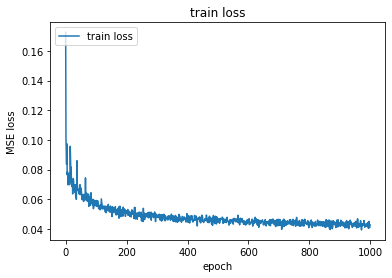

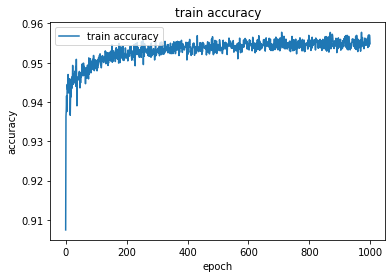

In [13]:
ini = time.time()

continueTrain = False

if (continueTrain):
    filename = './cells-256-1000-30-v3.h5'
    model = keras.models.load_model(filename);
    versao += 1


history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, 
                        validation_steps=valid_steps, epochs=epochs);
filename = _fileName % (image_size, epochs, versao)

fim = time.time()

print("Tempo:", fim-ini)

model.save(filename);
impHistoria(history)

In [14]:
#model = keras.models.load_model(filename);
#model = keras.models.load_model("cells-256-1000-30-v1.h5");
model.evaluate(valid_gen)

1/1 [==============================] - 1s 1s/step - loss: 0.0717 - acc: 0.9561


[0.07170800864696503, 0.9560546875]

# PREDICT

In [ ]:

## Dataset for prediction
p_image, p_mask = train_gen.__getitem__(0); #accessed as normalised bool

print("shape image: ", p_image.shape, "shape mask: ", p_mask.shape)

result_mask = model.predict(p_image); #collection of 10 masks

print("result_mask shape: ", result_mask.shape);
result_mask = result_mask > 0.50; #float probability to bool conversion

plt.imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
plt.show()




shape image:  (1, 256, 256, 3) shape mask:  (1, 256, 256, 1)
result_mask shape:  (1, 256, 256, 1)


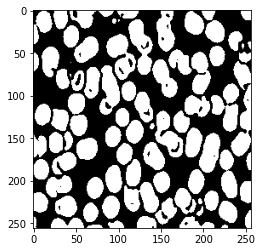

In [46]:

## Dataset for prediction
p_image, p_mask = train_gen.__getitem__(0); #accessed as normalised bool

print("shape image: ", p_image.shape, "shape mask: ", p_mask.shape)

result_mask = model.predict(p_image); #collection of 10 masks

print("result_mask shape: ", result_mask.shape);
result_mask = result_mask > 0.50; #float probability to bool conversion

plt.imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
plt.show()




Text(0.5, 1.0, 'Predicted mask')

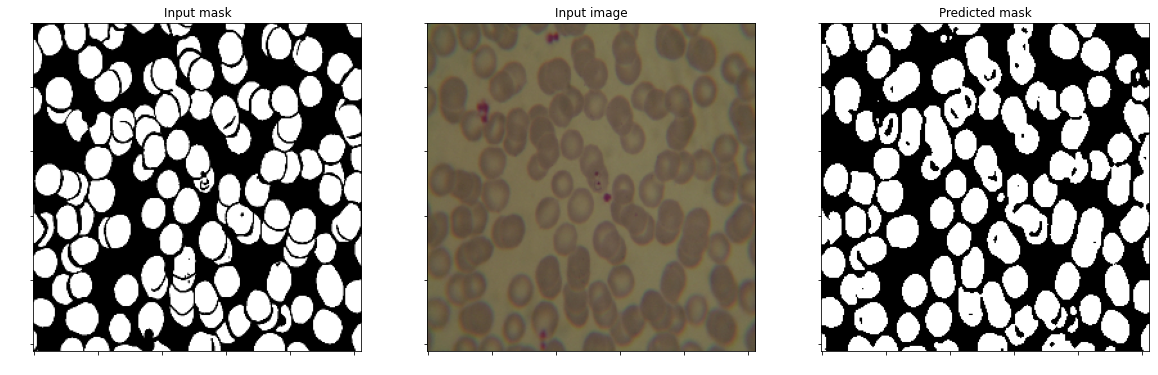

In [47]:


fig1 = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=.4, wspace=.6)
i = 0;
my_plot = fig1.add_subplot(1, 3, 1)
plt.title("Input mask")
plt.xticks(color='w')
plt.yticks(color='w')
my_plot.imshow(np.reshape(p_mask[i]*255, (image_size, image_size)), cmap="gray")

my_plot = fig1.add_subplot(1, 3, 2);
p_image2 = p_image[i][:,:,::-1]
my_plot.imshow(p_image2);
plt.xticks(color='w')
plt.yticks(color='w')
plt.title("Input image")

my_plot = fig1.add_subplot(1, 3, 3)
my_plot.imshow(np.reshape(result_mask[i]*255, (image_size, image_size)), cmap="gray")
plt.xticks(color='w')
plt.yticks(color='w')
plt.title("Predicted mask")

result_mask shape:  (1, 256, 256, 1)


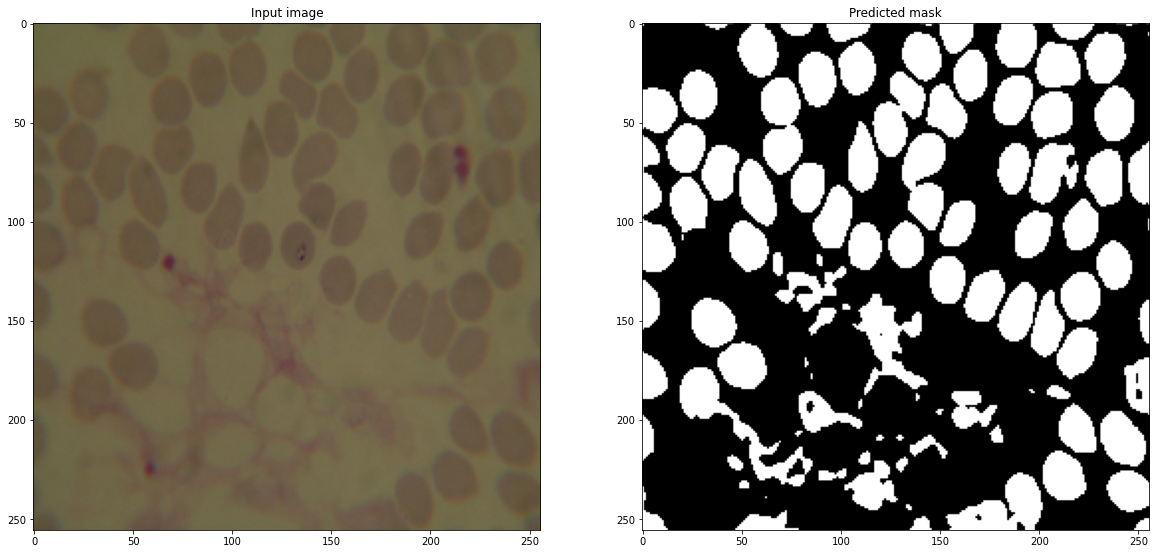

In [48]:
def load_img_norm(image_path, image_size):
        image = cv2.imread(image_path, 1); #reading image to image vaiable
        image = cv2.resize(image, (image_size, image_size));# resizing input image to 128 * 128
        #image normalisation
        image = image / 255.0;
        
        image_r = []
        image_r.append(image);
        image_r = np.array(image_r);
        return image_r;

## Dataset for prediction
p_image = load_img_norm(gdrive+"/data-1024x1024/images/blood_smear_3.JPG",image_size)

result_mask = model.predict(p_image); #collection of 10 masks

print("result_mask shape: ", result_mask.shape);

#plt.imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
#plt.show()

result_mask = result_mask > 0.30; #float probability to bool conversion

fig, ax = plt.subplots(ncols=2, figsize=(20,20))

res = p_image[0][:,:,::-1]
ax[0].imshow(res);
ax[0].title.set_text("Input image")

ax[1].imshow(np.reshape(result_mask[0]*255, (image_size, image_size)), cmap="gray")
ax[1].title.set_text("Predicted mask")

In [49]:
inputs = keras.layers.Input((128, 128, 3))
c = keras.layers.Conv2D(64, (3,3), padding='same', strides=1, activation="relu")(inputs)
w = c.node.layer.get_weights()
w = w[0][0][0][0]
plt.plot(w)
plt.show()

print (min(w), max(w))

AttributeError: 'KerasTensor' object has no attribute 'node'

In [ ]:
for i in range(10,31):
    image = cv2.imread(gdrive+"/data-1024x1024/masks/blood_smear_%d.png" % i)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    print("blood_smear_%d.png" % i)
    hist /= hist.sum()
    for i in range(256):
        if hist[i][0] > 0:
            print(i,end=",")
    print("")


In [ ]:
image = cv2.imread(gdrive+"/data-1024x1024/masks/blood_smear_1.png")
hist = cv2.calcHist([image], [0], None, [256], [0, 256])

hist /= hist.sum()
for i in range(256):
    if hist[i][0] > 0:
        print(i)
# plot the normalized histogram
plt.figure()
plt.title("Grayscale Histogram (Normalized)")
plt.xlabel("Bins")
plt.ylabel("% of Pixels")
plt.plot(hist)
plt.xlim([0, 256])
plt.show()